# Module 4 - Non linear modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score, average_precision_score
import random
from catboost import CatBoostClassifier, Pool

In [2]:
data = pd.read_csv(r"/home/raquel/zrive-ds/src/module_3/feature_frame.csv")

In [3]:
#Orders with more than 5 products
purchases = data[data["outcome"] == 1]
purchases = purchases.groupby("order_id").size().reset_index(name="n_products")
purch_5_prod = purchases[purchases["n_products"] >= 5]

The previous DataFrame contains the products purchased in each of the orders with more than 5 products. I complete the dataset with those products that have NOT been purchased in these baskets

In [4]:
purch_5_prod = data[data["order_id"].isin(purch_5_prod["order_id"])]
print(purch_5_prod.shape)

(2163953, 27)


In [5]:
# For a recommendation algorithm, I think it could be useful to create a feature that extracts the month of the purchase.
purch_5_prod = purch_5_prod.assign(
    created_at=lambda x: pd.to_datetime(x.created_at),
    month_created=lambda x: x.created_at.dt.month,
    order_date = lambda x:pd.to_datetime(x.order_date)
)
purch_5_prod.head(2)

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,month_created
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,...,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,10
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05,2,0.0,0.0,0.0,...,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,10


# Train-Val-Test split

Im'm going to do a common train-val-test split for all the models. 
- The train subset for ensemble learning will be divided as corresponds in each model.
- The validation subset will be the tool to identify overfitting.
- The test subset will be the final proof.

In [6]:
#To avoid information leakage, I will follow the chronological order and all products from the same order within the same subset
daily_orders = purch_5_prod.groupby("order_date").order_id.nunique()
cumsum_daily_orders = daily_orders.cumsum()/daily_orders.sum()

train_val_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.7].idxmax()
val_test_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.9].idxmax()

print("Train since", cumsum_daily_orders.index.min())
print("Train until", train_val_cutoff)
print("Val until", val_test_cutoff)
print("Test until", cumsum_daily_orders.index.max())

Train since 2020-10-05 00:00:00
Train until 2021-02-04 00:00:00
Val until 2021-02-22 00:00:00
Test until 2021-03-03 00:00:00


In [7]:
train_df = purch_5_prod[purch_5_prod.order_date <= train_val_cutoff]
val_df = purch_5_prod[(purch_5_prod.order_date > train_val_cutoff) & (purch_5_prod.order_date <= val_test_cutoff)]
test_df = purch_5_prod[purch_5_prod.order_date > val_test_cutoff]

In [8]:
# Without predictive power
info_cols = ["variant_id", "order_id", "user_id", "created_at", "order_date"]
label_col = "outcome"
feature_cols = [
    col for col in purch_5_prod.columns if col not in info_cols + [label_col]
]
# Breaking down the features
categorical_cols = ["product_type", "vendor"]
binary_cols = ["ordered_before", "abandoned_before", "active_snoozed", "set_as_regular"]
numerical_cols = [
    col for col in feature_cols if col not in categorical_cols + binary_cols
]
train_cols = numerical_cols + binary_cols  

In [9]:
X_train = train_df.drop(label_col,axis=1)
y_train = train_df[label_col]
X_val= val_df.drop(label_col,axis=1)
y_val= val_df['outcome']

In [10]:
def evaluate_model(
        clf,
        X_train,
        y_train,
        X_val,
        y_val,
        train_aucs_list,
        val_aucs_list,
        train_aps_list,
        val_aps_list,
):
    train_preds = clf.predict_proba(X_train)[:,1]
    val_preds = clf.predict_proba(X_val)[:,1]
    train_auc = roc_auc_score(y_train,train_preds)
    val_auc = roc_auc_score(y_val,val_preds)
    train_ap = average_precision_score(y_train,train_preds)
    val_ap = average_precision_score(y_val,val_preds)

    train_aucs_list.append(train_auc)
    val_aucs_list.append(val_auc)
    train_aps_list.append(train_ap)
    val_aps_list.append(val_ap)

def plot_feature_importance(clf, columns):
    fig, ax = plt.subplots()
    fi = pd.DataFrame(
        list(zip(columns, clf.feature_importances_)),columns=["features","importance"]).sort_values(by="importance",ascending=True)
    fi.plot(kind="barh",x="features",y="importance",ax=ax)
    return fi, fig, ax 
    

First, I'm going to avoid categorical variables

In [11]:
train_cols = numerical_cols + binary_cols

# Linear Baseline

Ridge

In [64]:
lr_ridge_train_aucs_list = []
lr_ridge_val_aucs_list = []
lr_ridge_train_aps_list = []
lr_ridge_val_aps_list = []
cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4]
for c in cs:
    lr = make_pipeline(StandardScaler(), LogisticRegression(penalty="l2", C=c))
    lr.fit(X_train[train_cols],y_train)
    evaluate_model(
        lr,
        X_train[train_cols],
        y_train,
        X_val[train_cols],
        y_val,
        lr_ridge_train_aucs_list,
        lr_ridge_val_aucs_list,
        lr_ridge_train_aps_list,
        lr_ridge_val_aps_list
    )

    print(
        f"LR Ridge c={c}: train_auc= {lr_ridge_train_aucs_list[-1]:.4f} and val_auc= {lr_ridge_val_aucs_list[-1]:.4f}."
        f" Train_ap= {lr_ridge_train_aps_list[-1]:.4f} and val_ap= {lr_ridge_val_aps_list[-1]:.4f}."
    )

LR Ridge c=1e-08: train_auc= 0.8242 and val_auc= 0.8319. Train_ap= 0.1561 and val_ap= 0.1602.
LR Ridge c=1e-06: train_auc= 0.8249 and val_auc= 0.8326. Train_ap= 0.1564 and val_ap= 0.1603.
LR Ridge c=0.0001: train_auc= 0.8114 and val_auc= 0.8240. Train_ap= 0.1602 and val_ap= 0.1585.
LR Ridge c=0.01: train_auc= 0.7983 and val_auc= 0.8130. Train_ap= 0.1585 and val_ap= 0.1557.
LR Ridge c=1: train_auc= 0.7980 and val_auc= 0.8127. Train_ap= 0.1585 and val_ap= 0.1557.
LR Ridge c=100: train_auc= 0.7980 and val_auc= 0.8127. Train_ap= 0.1585 and val_ap= 0.1557.
LR Ridge c=10000.0: train_auc= 0.7980 and val_auc= 0.8127. Train_ap= 0.1585 and val_ap= 0.1557.


Se ve como en ninguno de los valores de regularización se consigue overfitting, aunque se ve mejor resultado con c=1e-06

Lasso

In [63]:
lr_lasso_train_aucs_list = []
lr_lasso_val_aucs_list = []
lr_lasso_train_aps_list = []
lr_lasso_val_aps_list = []
cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4]
for c in cs:
    lr = make_pipeline(StandardScaler(), LogisticRegression(penalty="l1", C=c, solver="saga"))
    lr.fit(X_train[train_cols],y_train)
    evaluate_model(
        lr,
        X_train[train_cols],
        y_train,
        X_val[train_cols],
        y_val,
        lr_lasso_train_aucs_list,
        lr_lasso_val_aucs_list,
        lr_lasso_train_aps_list,
        lr_lasso_val_aps_list
    )

    print(
        f"LR Lasso c={c}: train_auc= {lr_lasso_train_aucs_list[-1]:.4f} and val_auc= {lr_lasso_val_aucs_list[-1]:.4f}."
        f" Train_ap= {lr_lasso_train_aps_list[-1]:.4f} and val_ap= {lr_lasso_val_aps_list[-1]:.4f}."
    )

LR Lasso c=1e-08: train_auc= 0.5000 and val_auc= 0.5000. Train_ap= 0.0151 and val_ap= 0.0135.
LR Lasso c=1e-06: train_auc= 0.5000 and val_auc= 0.5000. Train_ap= 0.0151 and val_ap= 0.0135.
LR Lasso c=0.0001: train_auc= 0.8330 and val_auc= 0.8344. Train_ap= 0.1615 and val_ap= 0.1484.
LR Lasso c=0.01: train_auc= 0.7996 and val_auc= 0.8143. Train_ap= 0.1587 and val_ap= 0.1563.
LR Lasso c=1: train_auc= 0.7979 and val_auc= 0.8126. Train_ap= 0.1585 and val_ap= 0.1558.
LR Lasso c=100: train_auc= 0.7979 and val_auc= 0.8126. Train_ap= 0.1585 and val_ap= 0.1558.
LR Lasso c=10000.0: train_auc= 0.7979 and val_auc= 0.8126. Train_ap= 0.1585 and val_ap= 0.1558.


Como el mejor val_auc se ha obtenido en el Ridge con c=1e-06, sacaré el feature importance y será el baseline de referencia.

In [175]:
lr = Pipeline(
    [
        ("standard_scaler",StandardScaler()), 
        ("lr", LogisticRegression(penalty="l2", C=1e-6)),
    ]
)
lr.fit(X_train[train_cols],y_train)
lr_coeff = pd.DataFrame({
    "features": train_cols,
    "importance": np.abs(lr.named_steps["lr"].coef_[0])
}).sort_values(by="importance",ascending=True)

<Axes: ylabel='features'>

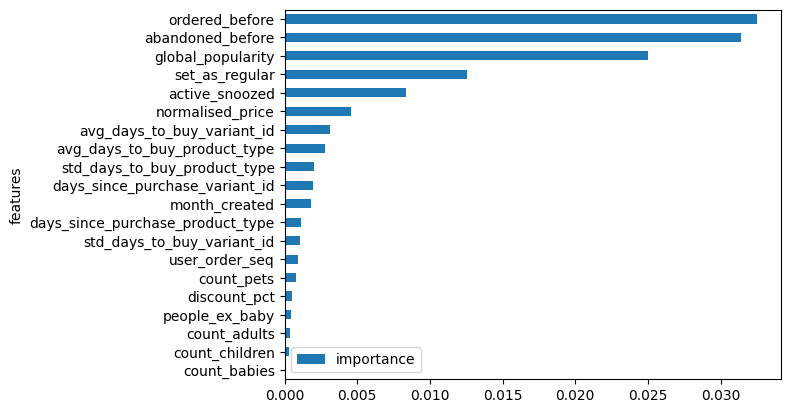

In [181]:
lr_coeff.plot(kind='barh',x="features",y="importance")

Suprimo las cinco últimas y reentreno Ridge

In [ ]:
lr_filtered_cols = lr_coeff["features"].iloc[-15:]

7                           count_pets
0                       user_order_seq
11          std_days_to_buy_variant_id
12    days_since_purchase_product_type
15                       month_created
9       days_since_purchase_variant_id
14        std_days_to_buy_product_type
13        avg_days_to_buy_product_type
10          avg_days_to_buy_variant_id
1                     normalised_price
18                      active_snoozed
19                      set_as_regular
3                    global_popularity
17                    abandoned_before
16                      ordered_before
Name: features, dtype: object

In [ ]:
lr_ridge_train_aucs_list = []
lr_ridge_val_aucs_list = []
lr_ridge_train_aps_list = []
lr_ridge_val_aps_list = []
cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4]
for c in cs:
    lr = make_pipeline(StandardScaler(), LogisticRegression(penalty="l2", C=c))
    lr.fit(X_train[lr_filtered_cols],y_train)
    evaluate_model(
        lr,
        X_train[lr_filtered_cols],
        y_train,
        X_val[lr_filtered_cols],
        y_val,
        lr_ridge_train_aucs_list,
        lr_ridge_val_aucs_list,
        lr_ridge_train_aps_list,
        lr_ridge_val_aps_list
    )

    print(
        f"LR Ridge c={c}: train_auc= {lr_ridge_train_aucs_list[-1]:.4f} and val_auc= {lr_ridge_val_aucs_list[-1]:.4f}."
        f" Train_ap= {lr_ridge_train_aps_list[-1]:.4f} and val_ap= {lr_ridge_val_aps_list[-1]:.4f}."
    )

LR Ridge c=1e-08: train_auc= 0.8249 and val_auc= 0.8323. Train_ap= 0.1563 and val_auc= 0.1603.
LR Ridge c=1e-06: train_auc= 0.8254 and val_auc= 0.8328. Train_ap= 0.1565 and val_auc= 0.1604.
LR Ridge c=0.0001: train_auc= 0.8118 and val_auc= 0.8244. Train_ap= 0.1602 and val_auc= 0.1585.
LR Ridge c=0.01: train_auc= 0.7982 and val_auc= 0.8131. Train_ap= 0.1585 and val_auc= 0.1560.
LR Ridge c=1: train_auc= 0.7980 and val_auc= 0.8129. Train_ap= 0.1585 and val_auc= 0.1559.
LR Ridge c=100: train_auc= 0.7980 and val_auc= 0.8129. Train_ap= 0.1585 and val_auc= 0.1559.
LR Ridge c=10000.0: train_auc= 0.7980 and val_auc= 0.8129. Train_ap= 0.1585 and val_auc= 0.1559.


El mejor sigue siendo con c=1e-06 con un val_ap = 0.1604 (BASELINE)

# Decision trees

In [ ]:
dt_train_aucs_list = []
dt_val_aucs_list = []
dt_train_aps_list = []
dt_val_aps_list = []
mds = [4, 5, 6, 8, 10]
for md in mds:
    dt=DecisionTreeClassifier(max_depth=md)
    dt.fit(X_train[train_cols], y_train)
    evaluate_model(
        dt,
        X_train[train_cols],
        y_train,
        X_val[train_cols],
        y_val,
        dt_train_aucs_list,
        dt_val_aucs_list,
        dt_train_aps_list,
        dt_val_aps_list
    )

    print(
        f"Decision Tree max_depth={md}: train_auc= {dt_train_aucs_list[-1]:.4f} and val_auc= {dt_val_aucs_list[-1]:.4f}."
        f" Train_ap= {dt_train_aps_list[-1]:.4f} and val_ap= {dt_val_aps_list[-1]:.4f}."
    )

Decision Tree max_depth=4: train_auc= 0.8140 and val_auc= 0.8101. Train_ap= 0.1386 and val_auc= 0.1265.
Decision Tree max_depth=5: train_auc= 0.8171 and val_auc= 0.8182. Train_ap= 0.1549 and val_auc= 0.1457.
Decision Tree max_depth=6: train_auc= 0.8314 and val_auc= 0.8336. Train_ap= 0.1695 and val_auc= 0.1554.
Decision Tree max_depth=8: train_auc= 0.8384 and val_auc= 0.8363. Train_ap= 0.1924 and val_auc= 0.1595.
Decision Tree max_depth=10: train_auc= 0.8428 and val_auc= 0.8252. Train_ap= 0.2161 and val_auc= 0.1442.


It can be seen that starting from a 'max_depth' of 8, the validation error begins to increase in the AP and with max_depth = 10 it is also apreciated in the ROC auc.
The best result without overfitting is achieved with max_depth = 8.

In [126]:
dt = DecisionTreeClassifier(max_depth=8)
dt.fit(X_train[train_cols],y_train)

DecisionTreeClassifier(max_depth=8)

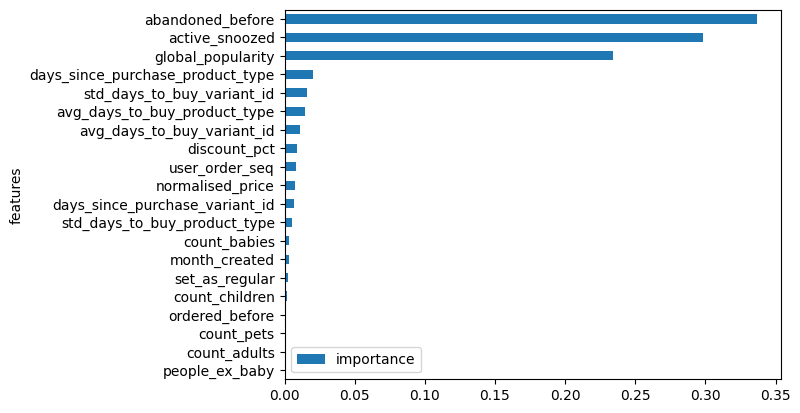

In [142]:
dt_fi, fig, ax = plot_feature_importance(dt,train_cols)

I'm going to drop the variables after 'count_babies'

In [147]:
filtered_cols = [
    "abandoned_before",
    "active_snoozed",
    "global_popularity",
    "days_since_purchase_product_type",
    "std_days_to_buy_variant_id",
    "avg_days_to_buy_product_type",
    "avg_days_to_buy_variant_id",
    "discount_pct",
    "user_order_seq",
    "normalised_price",
    "days_since_purchase_variant_id",
    "std_days_to_buy_product_type"
]


In [ ]:
dt_train_aucs_list = []
dt_val_aucs_list = []
dt_train_aps_list = []
dt_val_aps_list = []
mds = [4, 5, 6, 8, 10]
for md in mds:
    dt=DecisionTreeClassifier(max_depth=md)
    dt.fit(X_train[filtered_cols], y_train)
    evaluate_model(
        dt,
        X_train[filtered_cols],
        y_train,
        X_val[filtered_cols],
        y_val,
        dt_train_aucs_list,
        dt_val_aucs_list,
        dt_train_aps_list,
        dt_val_aps_list
    )

    print(
        f"Decision Tree max_depth={md}: train_auc= {dt_train_aucs_list[-1]:.4f} and val_auc= {dt_val_aucs_list[-1]:.4f}."
        f" Train_ap= {dt_train_aps_list[-1]:.4f} and val_ap= {dt_val_aps_list[-1]:.4f}."
    )

Decision Tree max_depth=4: train_auc= 0.7423 and val_auc= 0.7451. Train_ap= 0.1230 and val_auc= 0.1199.
Decision Tree max_depth=5: train_auc= 0.7996 and val_auc= 0.8056. Train_ap= 0.1413 and val_auc= 0.1406.
Decision Tree max_depth=6: train_auc= 0.8135 and val_auc= 0.8212. Train_ap= 0.1537 and val_auc= 0.1515.
Decision Tree max_depth=8: train_auc= 0.8248 and val_auc= 0.8286. Train_ap= 0.1757 and val_auc= 0.1634.
Decision Tree max_depth=10: train_auc= 0.8297 and val_auc= 0.8276. Train_ap= 0.1971 and val_auc= 0.1469.


El que presenta mejor resultado de nuevo es el de max_depth = 8, e incluso mejor que sin el feature importance

# Random Forest

I'm going to try with maximun depth of the trees and different number of trees

In [185]:
rf_train_aucs_list = []
rf_val_aucs_list = []
rf_train_aps_list = []
rf_val_aps_list = []
n_trees = [5, 25, 50, 100, 120]
for n_tree in n_trees:
    rf=RandomForestClassifier(n_estimators=n_tree)
    rf.fit(X_train[train_cols], y_train)
    evaluate_model(
        rf,
        X_train[train_cols],
        y_train,
        X_val[train_cols],
        y_val,
        rf_train_aucs_list,
        rf_val_aucs_list,
        rf_train_aps_list,
        rf_val_aps_list
    )

    print(
        f"Random Forest n_trees={n_tree}: train_auc= {rf_train_aucs_list[-1]:.4f} and val_auc= {rf_val_aucs_list[-1]:.4f}."
        f" Train_ap= {rf_train_aps_list[-1]:.4f} and val_ap= {rf_val_aps_list[-1]:.4f}."
    )


Random Forest n_trees=5: train_auc= 0.9900 and val_auc= 0.6530. Train_ap= 0.7722 and val_ap= 0.0824.
Random Forest n_trees=25: train_auc= 0.9953 and val_auc= 0.7360. Train_ap= 0.8543 and val_ap= 0.1318.
Random Forest n_trees=50: train_auc= 0.9957 and val_auc= 0.7579. Train_ap= 0.8617 and val_ap= 0.1405.
Random Forest n_trees=100: train_auc= 0.9958 and val_auc= 0.7769. Train_ap= 0.8650 and val_ap= 0.1474.
Random Forest n_trees=120: train_auc= 0.9959 and val_auc= 0.7800. Train_ap= 0.8653 and val_ap= 0.1463.


El mejor resultado se encuentra con n_trees = 100. Estudio el feature importance para esa configuración

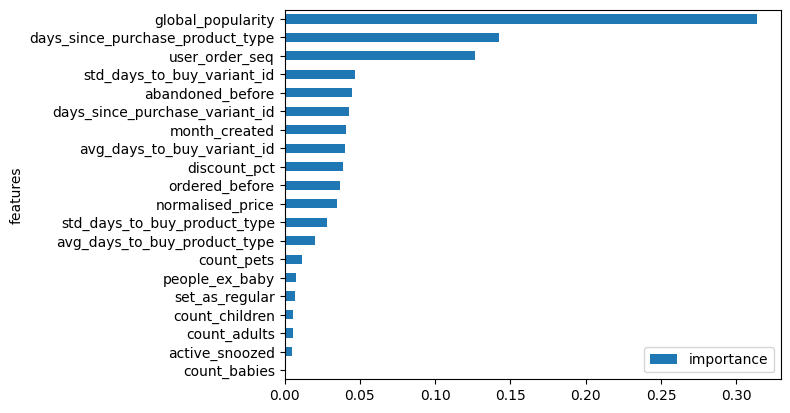

In [186]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train[train_cols],y_train)
rf_fi, fig, ax = plot_feature_importance(rf,train_cols)

Suprimo las 5 últimas y reentreno

In [194]:
rf_filtered_columns = rf_fi["features"].iloc[-14:]
rf_filtered_columns

7                           count_pets
13        avg_days_to_buy_product_type
14        std_days_to_buy_product_type
1                     normalised_price
16                      ordered_before
2                         discount_pct
10          avg_days_to_buy_variant_id
15                       month_created
9       days_since_purchase_variant_id
17                    abandoned_before
11          std_days_to_buy_variant_id
0                       user_order_seq
12    days_since_purchase_product_type
3                    global_popularity
Name: features, dtype: object

In [192]:
rf_train_aucs_list = []
rf_val_aucs_list = []
rf_train_aps_list = []
rf_val_aps_list = []
n_trees = [5, 25, 50, 100, 120]
for n_tree in n_trees:
    rf=RandomForestClassifier(n_estimators=n_tree)
    rf.fit(X_train[rf_filtered_columns], y_train)
    evaluate_model(
        rf,
        X_train[rf_filtered_columns],
        y_train,
        X_val[rf_filtered_columns],
        y_val,
        rf_train_aucs_list,
        rf_val_aucs_list,
        rf_train_aps_list,
        rf_val_aps_list
    )

    print(
        f"Random Forest n_trees={n_tree}: train_auc= {rf_train_aucs_list[-1]:.4f} and val_auc= {rf_val_aucs_list[-1]:.4f}."
        f" Train_ap= {rf_train_aps_list[-1]:.4f} and val_ap= {rf_val_aps_list[-1]:.4f}."
    )

Random Forest n_trees=5: train_auc= 0.9900 and val_auc= 0.6320. Train_ap= 0.7642 and val_ap= 0.0736.
Random Forest n_trees=25: train_auc= 0.9950 and val_auc= 0.7167. Train_ap= 0.8464 and val_ap= 0.1149.
Random Forest n_trees=50: train_auc= 0.9954 and val_auc= 0.7455. Train_ap= 0.8538 and val_ap= 0.1264.
Random Forest n_trees=100: train_auc= 0.9956 and val_auc= 0.7684. Train_ap= 0.8570 and val_ap= 0.1317.
Random Forest n_trees=120: train_auc= 0.9956 and val_auc= 0.7693. Train_ap= 0.8577 and val_ap= 0.1309.


Ha empeorado suprimiendo esas variables

# XGBoost

In [199]:
n_trees_grid = [100, 120, 150, 170, 200]
xg_train_aucs_list = []
xg_val_aucs_list = []
xg_train_aps_list = []
xg_val_aps_list = []

for lr in [0.05,0.01]:
    for depth in [5, 7, 10, 12, 15]:
        for n_tree in n_trees_grid:
            xg=XGBClassifier(max_depth = depth, learning_rate = lr, n_estimators=n_tree)
            xg.fit(X_train[train_cols], y_train)
            evaluate_model(
                xg,
                X_train[train_cols],
                y_train,
                X_val[train_cols],
                y_val,
                xg_train_aucs_list,
                xg_val_aucs_list,
                xg_train_aps_list,
                xg_val_aps_list
            )

            print(
                f"XGBoost n_trees={n_tree}, max_depth = {depth}, learning_rate = {lr} :" 
                f"train_auc= {xg_train_aucs_list[-1]:.4f} and val_auc= {xg_val_aucs_list[-1]:.4f}."
                f" Train_ap= {xg_train_aps_list[-1]:.4f} and val_ap= {xg_val_aps_list[-1]:.4f}."
            )

XGBoost n_trees=100, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8441 and val_auc= 0.8460. Train_ap= 0.2112 and val_ap= 0.1965.
XGBoost n_trees=120, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8454 and val_auc= 0.8465. Train_ap= 0.2134 and val_ap= 0.1971.
XGBoost n_trees=150, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8470 and val_auc= 0.8469. Train_ap= 0.2160 and val_ap= 0.1973.
XGBoost n_trees=170, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8480 and val_auc= 0.8469. Train_ap= 0.2177 and val_ap= 0.1972.
XGBoost n_trees=200, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8492 and val_auc= 0.8466. Train_ap= 0.2207 and val_ap= 0.1972.
XGBoost n_trees=100, max_depth = 7, learning_rate = 0.05 :train_auc= 0.8497 and val_auc= 0.8475. Train_ap= 0.2358 and val_ap= 0.1996.
XGBoost n_trees=120, max_depth = 7, learning_rate = 0.05 :train_auc= 0.8512 and val_auc= 0.8475. Train_ap= 0.2390 and val_ap= 0.1991.
XGBoost n_trees=150, max_depth = 7, learning_rate = 0.05 :trai

Pruebo con Random Search en vez de Grid Search

In [202]:
n_trees = list(range(50, 300, 50))
lrs= [0.01, 0.05, 0.08, 0.1, 0.2]
depths = [5, 7, 10, 12, 15, 18, 20, 25, 30, 35]
n_iter = 50
xg_train_aucs_list = []
xg_val_aucs_list = []
xg_train_aps_list = []
xg_val_aps_list = []

for i in range(0,n_iter):
    lr = random.choice(lrs)
    depth = random.choice(depths)
    n_tree = random.choice(n_trees)
    xg=XGBClassifier(max_depth = depth, learning_rate = lr, n_estimators=n_tree)
    xg.fit(X_train[train_cols], y_train)
    evaluate_model(
        xg,
        X_train[train_cols],
        y_train,
        X_val[train_cols],
        y_val,
        xg_train_aucs_list,
        xg_val_aucs_list,
        xg_train_aps_list,
        xg_val_aps_list
    )

    print(
        f"XGBoost n_trees={n_tree}, max_depth = {depth}, learning_rate = {lr} :" 
        f"train_auc= {xg_train_aucs_list[-1]:.4f} and val_auc= {xg_val_aucs_list[-1]:.4f}."
        f" Train_ap= {xg_train_aps_list[-1]:.4f} and val_ap= {xg_val_aps_list[-1]:.4f}."
    )

XGBoost n_trees=250, max_depth = 5, learning_rate = 0.1 :train_auc= 0.8576 and val_auc= 0.8435. Train_ap= 0.2411 and val_ap= 0.1938.
XGBoost n_trees=150, max_depth = 12, learning_rate = 0.08 :train_auc= 0.8989 and val_auc= 0.8376. Train_ap= 0.3839 and val_ap= 0.1815.
XGBoost n_trees=150, max_depth = 12, learning_rate = 0.01 :train_auc= 0.8560 and val_auc= 0.8446. Train_ap= 0.2794 and val_ap= 0.1888.
XGBoost n_trees=250, max_depth = 12, learning_rate = 0.2 :train_auc= 0.9553 and val_auc= 0.8000. Train_ap= 0.5869 and val_ap= 0.1451.
XGBoost n_trees=50, max_depth = 15, learning_rate = 0.05 :train_auc= 0.8866 and val_auc= 0.8433. Train_ap= 0.3728 and val_ap= 0.1799.
XGBoost n_trees=150, max_depth = 15, learning_rate = 0.08 :train_auc= 0.9321 and val_auc= 0.8285. Train_ap= 0.4939 and val_ap= 0.1686.
XGBoost n_trees=150, max_depth = 20, learning_rate = 0.08 :train_auc= 0.9684 and val_auc= 0.8165. Train_ap= 0.6455 and val_ap= 0.1516.
XGBoost n_trees=200, max_depth = 15, learning_rate = 0.2 :t

El mejor resultado fue obtenido con n_trees=100, max_depth = 7, learning_rate = 0.05. Estudio el feature importance de esa configuración

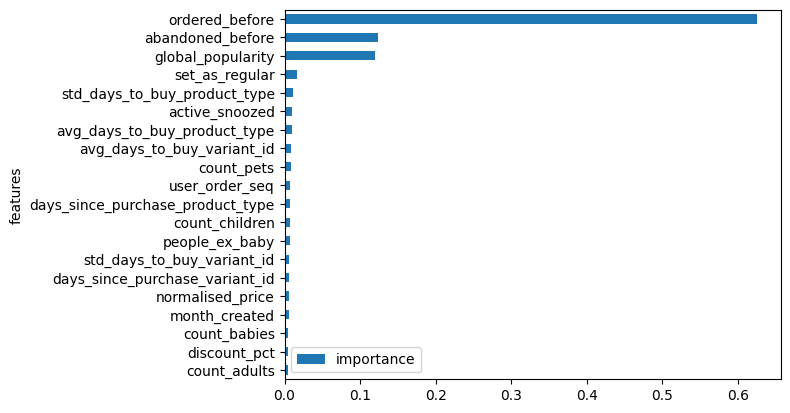

In [203]:
xg = XGBClassifier(learning_rate=0.05, max_depth = 7, n_estimators=100)
xg.fit(X_train[train_cols],y_train)
xg_fi, fig, ax = plot_feature_importance(xg,train_cols)

In [209]:
xg_filtered_columns = xg_fi["features"].iloc[-15:]
xg_filtered_columns

9       days_since_purchase_variant_id
11          std_days_to_buy_variant_id
8                       people_ex_baby
5                       count_children
12    days_since_purchase_product_type
0                       user_order_seq
7                           count_pets
10          avg_days_to_buy_variant_id
13        avg_days_to_buy_product_type
18                      active_snoozed
14        std_days_to_buy_product_type
19                      set_as_regular
3                    global_popularity
17                    abandoned_before
16                      ordered_before
Name: features, dtype: object

In [210]:
n_trees_grid = [100, 120, 150, 170, 200]
xg_train_aucs_list = []
xg_val_aucs_list = []
xg_train_aps_list = []
xg_val_aps_list = []

for lr in [0.05,0.01]:
    for depth in [5, 7, 10, 12, 15]:
        for n_tree in n_trees_grid:
            xg=XGBClassifier(max_depth = depth, learning_rate = lr, n_estimators=n_tree)
            xg.fit(X_train[xg_filtered_columns], y_train)
            evaluate_model(
                xg,
                X_train[xg_filtered_columns],
                y_train,
                X_val[xg_filtered_columns],
                y_val,
                xg_train_aucs_list,
                xg_val_aucs_list,
                xg_train_aps_list,
                xg_val_aps_list
            )

            print(
                f"XGBoost n_trees={n_tree}, max_depth = {depth}, learning_rate = {lr} :" 
                f"train_auc= {xg_train_aucs_list[-1]:.4f} and val_auc= {xg_val_aucs_list[-1]:.4f}."
                f" Train_ap= {xg_train_aps_list[-1]:.4f} and val_ap= {xg_val_aps_list[-1]:.4f}."
            )

XGBoost n_trees=100, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8435 and val_auc= 0.8456. Train_ap= 0.2092 and val_ap= 0.1970.
XGBoost n_trees=120, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8447 and val_auc= 0.8458. Train_ap= 0.2108 and val_ap= 0.1973.
XGBoost n_trees=150, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8457 and val_auc= 0.8457. Train_ap= 0.2128 and val_ap= 0.1969.
XGBoost n_trees=170, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8464 and val_auc= 0.8455. Train_ap= 0.2143 and val_ap= 0.1973.
XGBoost n_trees=200, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8473 and val_auc= 0.8452. Train_ap= 0.2166 and val_ap= 0.1969.
XGBoost n_trees=100, max_depth = 7, learning_rate = 0.05 :train_auc= 0.8481 and val_auc= 0.8459. Train_ap= 0.2310 and val_ap= 0.1988.
XGBoost n_trees=120, max_depth = 7, learning_rate = 0.05 :train_auc= 0.8492 and val_auc= 0.8456. Train_ap= 0.2330 and val_ap= 0.1979.
XGBoost n_trees=150, max_depth = 7, learning_rate = 0.05 :trai

Quitando variables no se ha conseguido mejorar la métrica de 0.1996

# CatBoost

In [11]:
cat_features=categorical_cols
X_train.head(1)

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,ordered_before,abandoned_before,active_snoozed,...,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,month_created
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,...,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,10


In [15]:
ca=CatBoostClassifier(max_depth = 7, learning_rate = 0.05, n_estimators=100,verbose=0)
ca.fit(X_train, y_train,cat_features)
pred_train = ca.predict_proba(X_train)[:,1]
pred_val = ca.predict_proba(X_val)[:,1]

In [16]:
train_auc = roc_auc_score(y_train,pred_train)
val_auc = roc_auc_score(y_val,pred_val)
train_ap = average_precision_score(y_train,pred_train)
val_ap = average_precision_score(y_val,pred_val)
print(
    f"'Train auc':{train_auc}, Val_auc: {val_auc}, 'Train_ap': {train_ap}, Val_ap: {val_ap}")

'Train auc':0.8419017206690603, Val_auc: 0.8447786039902896, 'Train_ap': 0.2134878728612839, Val_ap: 0.19605660963393498


In [12]:
n_trees_grid = [200, 210]
ca_train_aucs_list = []
ca_val_aucs_list = []
ca_train_aps_list = []
ca_val_aps_list = []

for lr in [0.05]:
    for depth in [5, 7]:
        for n_tree in n_trees_grid:
            ca=CatBoostClassifier(max_depth = depth, learning_rate = lr, n_estimators=n_tree,verbose=0)
            ca.fit(X_train, y_train, cat_features)
            evaluate_model(
                ca,
                X_train,
                y_train,
                X_val,
                y_val,
                ca_train_aucs_list,
                ca_val_aucs_list,
                ca_train_aps_list,
                ca_val_aps_list
            )

            print(
                f"CatBoost n_trees={n_tree}, max_depth = {depth}, learning_rate = {lr} :" 
                f"train_auc= {ca_train_aucs_list[-1]:.4f} and val_auc= {ca_val_aucs_list[-1]:.4f}."
                f" Train_ap= {ca_train_aps_list[-1]:.4f} and val_ap= {ca_val_aps_list[-1]:.4f}."
            )

CatBoost n_trees=200, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8437 and val_auc= 0.8450. Train_ap= 0.2146 and val_ap= 0.2012.
CatBoost n_trees=210, max_depth = 5, learning_rate = 0.05 :train_auc= 0.8441 and val_auc= 0.8456. Train_ap= 0.2154 and val_ap= 0.2014.
CatBoost n_trees=200, max_depth = 7, learning_rate = 0.05 :train_auc= 0.8476 and val_auc= 0.8479. Train_ap= 0.2301 and val_ap= 0.2020.
CatBoost n_trees=210, max_depth = 7, learning_rate = 0.05 :train_auc= 0.8479 and val_auc= 0.8480. Train_ap= 0.2315 and val_ap= 0.2025.


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
ax1, ax2, ax3, ax4 = axs.flatten()
#I take max_depth to control overfitting
mds = [2,4,8,10,12,16,32]
for md in mds:
    dt=DecisionTreeClassifier(max_depth=md)
    dt.fit(X_train[train_cols], y_train)
    train_proba = dt.predict_proba(X_train[train_cols])[:, 1]
    
    precision_train, recall_train, _ = precision_recall_curve(y_train, train_proba)
    pr_auc = roc_auc_score(y_train, train_proba)
    ax1.plot(recall_train, precision_train, label=f"DT; Max_depth={md}; PR AUC: {pr_auc:.2f}")
    fpr_train, tpr_train, _ = roc_curve(y_train, train_proba)
    roc_auc = roc_auc_score(y_train, train_proba)
    ax2.plot(fpr_train, tpr_train, label=f"DT; Max_depth={md}; ROC AUC = {roc_auc:.2f}:")
    # Validation curves
    val_proba = dt.predict_proba(X_val[train_cols])[:, 1]
    precision_val, recall_val, _ = precision_recall_curve(y_val, val_proba)
    pr_auc = roc_auc_score(y_val, val_proba)
    ax3.plot(recall_val, precision_val, label=f"DT; Max_depth={md}; PR AUC: {pr_auc:.2f}")
    fpr_val, tpr_val, _ = roc_curve(y_val, val_proba)
    roc_auc = roc_auc_score(y_val, val_proba)
    ax4.plot(fpr_val, tpr_val, label=f"DT; Max_depth={md}; ROC AUC: {roc_auc:.2f}")

# Adding Baseline validation

# Validation curves
y_val_baseline = w1 * X_val["global_popularity"] + w2 * X_val["ordered_before"]
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_baseline)
pr_auc = roc_auc_score(y_val, y_val_baseline)
ax3.plot(recall_val, precision_val, label=f"Baseline; PR AUC: {pr_auc:.2f}")
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_baseline)
roc_auc = roc_auc_score(y_val, y_val_baseline)
ax4.plot(fpr_val, tpr_val, label=f"Baseline; ROC AUC: {roc_auc:.2f}")

ax1.set_title("Precision-Recall")
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.legend()

ax2.set_title("ROC - Train")
ax2.set_xlabel("FPR (False Positive Rate)")
ax2.set_ylabel("TPR (True Positive Rate)")
ax2.legend()


ax3.set_title("Curva Precision-Recall - Validation")
ax3.set_xlabel("Recall")
ax3.set_ylabel("Precision")
ax3.legend()


ax4.set_title("ROC - Validation")
ax4.set_xlabel("FPR (False Positive Rate)")
ax4.set_ylabel("TPR (True Positive Rate)")
ax4.legend()

plt.tight_layout()
plt.show()